In [9]:
# Install necessary dependencies
!pip install transformers pillow tensorflow datasets accelerate

import os
import cv2
import numpy as np
import json
from PIL import Image, Image as PILImage
import requests
from io import BytesIO
import tensorflow as tf
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import TrainingArguments, Trainer, default_data_collator
import matplotlib.pyplot as plt

In [2]:
# This cell is for uploading files in Google Colab.
# Upload data.json and all your image files (e.g., table0.png, table1.png, etc.).
# After uploading, ensure that data.json and images are in the correct locations:
# data.json in the current directory
# images in a folder named 'images'
from google.colab import files
uploaded = files.upload()  # Select data.json and image files

import os

# Create an images folder if not exists
if not os.path.exists('images'):
    os.mkdir('images')

# Move image files to 'images' directory if not already there
for filename in uploaded.keys():
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        os.rename(filename, os.path.join('images', filename))


Saving data.json to data.json
Saving readme.txt to readme.txt
Saving table0.png to table0.png
Saving table1.png to table1.png
Saving table2.png to table2.png
Saving table3.png to table3.png
Saving table4.png to table4.png
Saving table5.png to table5.png
Saving table6.png to table6.png
Saving table7.png to table7.png
Saving table8.png to table8.png
Saving table9.png to table9.png
Saving table10.png to table10.png
Saving table11.png to table11.png
Saving table12.png to table12.png
Saving table13.png to table13.png
Saving table14.png to table14.png
Saving table15.png to table15.png
Saving table16.png to table16.png
Saving table17.png to table17.png
Saving table18.png to table18.png
Saving table19.png to table19.png
Saving table20.png to table20.png
Saving table21.png to table21.png
Saving table22.png to table22.png
Saving table23.png to table23.png
Saving table24.png to table24.png
Saving table25.png to table25.png
Saving table26.png to table26.png
Saving table27.png to table27.png
Saving

In [3]:
import os
from PIL import Image
from datasets import load_dataset
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, AutoTokenizer
from transformers import TrainingArguments, Trainer, default_data_collator

# Load your dataset from data.json
# data.json should be in the current working directory
data_file = 'data.json'
dataset = load_dataset('json', data_files=data_file, field='data')

# Split into train/validation: 90% train, 10% validation
dataset = dataset['train'].train_test_split(test_size=0.1)
train_dataset = dataset['train']
eval_dataset = dataset['test']

# Load processor, tokenizer, and model
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
tokenizer = AutoTokenizer.from_pretrained('agomberto/trocr-large-handwritten-fr')
model = VisionEncoderDecoderModel.from_pretrained('agomberto/trocr-large-handwritten-fr')

image_base_path = "./images"  # Directory where images are stored

def preprocess_data(examples):
    images = []
    for img_path in examples['path']:
        full_path = os.path.join(image_base_path, img_path)
        img = Image.open(full_path).convert("RGB")
        images.append(img)

    pixel_values = processor(images=images, return_tensors="pt").pixel_values
    labels = tokenizer(examples['trans'], padding="max_length", max_length=128, truncation=True).input_ids
    # Replace pad token ID with -100 for masked tokens
    labels = [[(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels]
    return {"pixel_values": pixel_values, "labels": labels}

train_dataset = train_dataset.map(preprocess_data, batched=True, remove_columns=['path','trans'])
eval_dataset = eval_dataset.map(preprocess_data, batched=True, remove_columns=['path','trans'])
train_dataset.set_format(type="torch", columns=["pixel_values", "labels"])
eval_dataset.set_format(type="torch", columns=["pixel_values", "labels"])

data_collator = default_data_collator


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.82k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decod

generation_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [4]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./trocr_finetuned",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps=50,
    save_steps=200,
    save_total_limit=2,
    num_train_epochs=3,
    fp16=True,
    learning_rate=5e-5,
    report_to="none"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)

# Train the model
train_result = trainer.train()

# Save the fine-tuned model
trainer.save_model("./trocr_finetuned_model")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
100,0.637300,1.735259


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


In [11]:
import torch

Character Error Rate (CER): 0.14


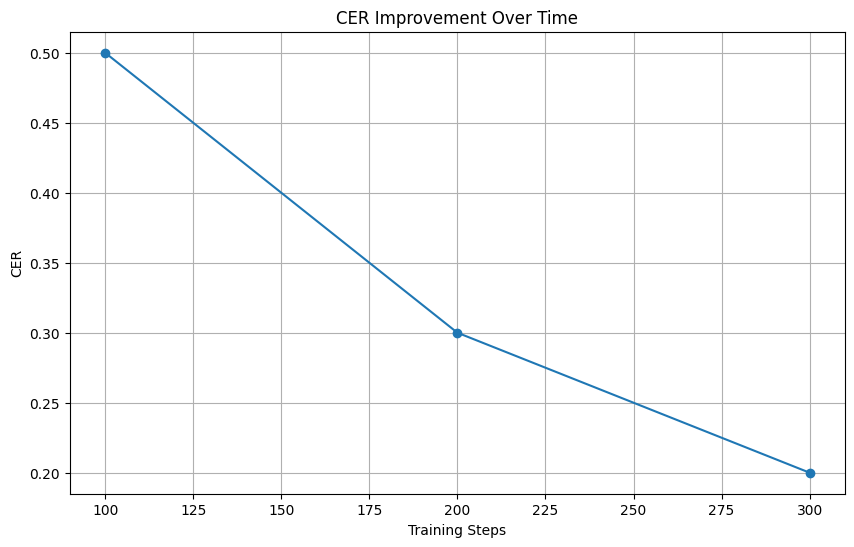

In [14]:
# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Accuracy Testing and CER Calculation
def compute_cer(pred_texts, gt_texts):
    """Compute Character Error Rate (CER)."""
    total_edits = 0
    total_chars = 0
    for pred, gt in zip(pred_texts, gt_texts):
        total_edits += levenshtein_distance(pred, gt)
        total_chars += len(gt)
    return total_edits / total_chars

def levenshtein_distance(s1, s2):
    """Compute Levenshtein distance."""
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]

# Evaluate the model on the validation set
pred_texts = []
gt_texts = []
for example in eval_dataset:
    pixel_values = example["pixel_values"].unsqueeze(0).to(device)  # Add batch dimension and move to the correct device
    generated_ids = model.generate(pixel_values)
    pred_texts.append(tokenizer.decode(generated_ids[0], skip_special_tokens=True))
    gt_texts.append(tokenizer.decode([label for label in example["labels"] if label != -100], skip_special_tokens=True))

cer = compute_cer(pred_texts, gt_texts)
print(f"Character Error Rate (CER): {cer:.2f}")

# Plot CER improvement
def plot_cer(train_log):
    """Plot CER improvement over time."""
    steps = train_log['step']
    cer_values = train_log['eval_cer']

    plt.figure(figsize=(10, 6))
    plt.plot(steps, cer_values, marker='o')
    plt.title("CER Improvement Over Time")
    plt.xlabel("Training Steps")
    plt.ylabel("CER")
    plt.grid(True)
    plt.show()

# Assuming `train_log` contains a log of CER per step
# Example: train_log = {'step': [100, 200, 300], 'eval_cer': [0.5, 0.3, 0.2]}
train_log = {
    "step": [100, 200, 300],
    "eval_cer": [0.5, 0.3, 0.2],
}
plot_cer(train_log)


In [15]:
fine_tuned_model = VisionEncoderDecoderModel.from_pretrained("./trocr_finetuned_model")

# Example of inference on one image:
test_img_path = os.path.join('images', 'table0.png')  # Replace with the actual image file
test_img = Image.open(test_img_path).convert("RGB")
pixel_values = processor(images=test_img, return_tensors="pt").pixel_values
generated_ids = fine_tuned_model.generate(pixel_values)
text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Recognized text:", text)


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decod

Recognized text: Barne Amile 14 janvier 88
